# Initiale Datevorbereitung

## Ziel

Die Rohdaten sollen bereinigt und in Training- und Test-Set gespalten werden

Das beinhaltet:

* Daten in Reihenfolge bringen
* Fehlerhafte Features entfernen
* Design einer sinnvollen Zielvariable / Variationen von Zielvariablen
* Zusammenfügen der Datensätze
* Daten randomisieren
* Aufteilen in Training- und Test-Set


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from datetime import datetime, timedelta, timezone

In [2]:
plt.rcParams["figure.figsize"] = (50,40)

In [3]:
failures_2016 = pd.read_csv("./data/init/failures-2016.csv", sep=";")
failures_2017 = pd.read_csv("./data/init/failures-2017.csv", sep=";")
metmast_2016 = pd.read_csv("./data/init/metmast-2016.csv", sep=";")
metmast_2017 = pd.read_csv("./data/init/metmast-2017.csv", sep=";")
signals_2016 = pd.read_csv("./data/init/signals-2016.csv", sep=";")
signals_2017 = pd.read_csv("./data/init/signals-2017.csv", sep=";")

## 1. Signale betrachten

### Signale beider Jahre kombinieren

In [4]:
signals = pd.concat([signals_2016, signals_2017])

In [5]:
signals.describe()

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
count,417141.000000,417141.000000,417141.000000,417141.000000,417137.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,...,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000
mean,1190.486434,936.670981,1067.096004,67.925213,46.116209,64.032723,64.076216,63.391827,35.423324,47.953663,...,-546.240281,-380.403486,-683.320405,74.822602,514.934477,670.799047,332.610897,81.835757,43.404427,179.561906
std,631.827468,607.263095,608.989196,110.784748,15.495703,27.459765,26.806766,26.083119,7.522915,6.580575,...,421.495029,389.854068,437.329736,96.191131,411.218061,435.151205,360.090459,99.078468,13.577242,96.053812
min,0.000000,0.000000,0.000000,0.000000,18.000000,19.000000,19.000000,19.000000,20.000000,24.000000,...,-1000.000000,-1000.000000,-1000.000000,0.000000,0.000000,0.000000,-200.000000,0.000000,19.000000,0.000000
25%,315.200000,194.800000,276.200000,13.300000,35.000000,43.000000,43.000000,43.000000,29.000000,43.000000,...,-988.700000,-613.600000,-1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,98.700000
50%,1417.700000,1231.100000,1274.600000,27.800000,44.000000,60.000000,61.000000,60.000000,34.000000,49.000000,...,-642.300000,-299.100000,-1000.000000,18.100000,528.600000,1000.000000,299.100000,32.400000,41.000000,138.300000
75%,1683.800000,1359.600000,1590.300000,71.200000,55.000000,76.000000,76.000000,76.000000,41.000000,53.000000,...,0.000000,0.000000,0.000000,140.800000,969.200000,1000.000000,540.200000,153.000000,52.000000,272.500000
max,2040.900000,1675.600000,1685.000000,823.100000,205.000000,205.000000,205.000000,205.000000,55.000000,65.000000,...,0.000000,200.000000,0.000000,500.000000,1000.000000,1000.000000,1000.000000,500.000000,205.000000,359.000000


### Die Signale für jede Turbine aufbereiten und plotten

In [6]:
turbine_names = signals["Turbine_ID"].unique()

In [7]:
def create_df_for_each_turbine(signals):
    turbine_dfs = list();

    for turbine in turbine_names:
        test = signals["Turbine_ID"]
        turbine_df = signals[signals["Turbine_ID"] == turbine]
        turbine_df = turbine_df.sort_values("Timestamp")
        turbine_df = turbine_df.reset_index()
        turbine_dfs.append(turbine_df)

    return turbine_dfs

turbine_dfs = create_df_for_each_turbine(signals)


In [8]:
def plot_data(df, title, n_agg, figsize=(10,9)):
    my_df = df.groupby(df.index // n_agg).agg("mean")
    fig, axs = plt.subplots(figsize[0], figsize[1])
    fig.suptitle(title)
    fig.tight_layout(pad=5.0)
    ctr2 = -1
    for i, col in enumerate(my_df):
        mod = i % figsize[0]
        if mod == 0: ctr2 +=1
        ax = axs[mod, ctr2]
        ax.scatter(x=my_df.index, y=my_df[col], s=1)
        ax.set_title(col)

In [9]:
# for i, df in enumerate(turbine_dfs):
    # plot_data(df, turbine_names[i], 20)

### Signale mit niedriger Varianz herausfiltern

In [10]:

def get_signals_with_low_variance(df, threshold=0):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    cont_data = df.select_dtypes(include=numerics)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(cont_data)
    inverted_list = ~np.array(selector.get_support())
    return cont_data.columns[inverted_list].tolist()

In [11]:
cols_to_drop = set()
for i, df in enumerate(turbine_dfs):
    cols_to_drop.update(get_signals_with_low_variance(df))

### Signale wieder zusammenführen

In [12]:
signals_clean = pd.concat(turbine_dfs)
signals_clean = signals_clean.drop(list(cols_to_drop), axis=1)

In [13]:
signals_clean.describe()

,index,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
count,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417137.000000,417141.000000,417141.000000,417141.000000,417141.000000,...,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000,417141.000000
mean,104285.811728,1190.486434,936.670981,1067.096004,67.925213,46.116209,64.032723,64.076216,63.391827,35.423324,...,-546.240281,-380.403486,-683.320405,74.822602,514.934477,670.799047,332.610897,81.835757,43.404427,179.561906
std,60211.028260,631.827468,607.263095,608.989196,110.784748,15.495703,27.459765,26.806766,26.083119,7.522915,...,421.495029,389.854068,437.329736,96.191131,411.218061,435.151205,360.090459,99.078468,13.577242,96.053812
min,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,19.000000,19.000000,19.000000,20.000000,...,-1000.000000,-1000.000000,-1000.000000,0.000000,0.000000,0.000000,-200.000000,0.000000,19.000000,0.000000
25%,52142.000000,315.200000,194.800000,276.200000,13.300000,35.000000,43.000000,43.000000,43.000000,29.000000,...,-988.700000,-613.600000,-1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,98.700000
50%,104285.000000,1417.700000,1231.100000,1274.600000,27.800000,44.000000,60.000000,61.000000,60.000000,34.000000,...,-642.300000,-299.100000,-1000.000000,18.100000,528.600000,1000.000000,299.100000,32.400000,41.000000,138.300000
75%,156427.000000,1683.800000,1359.600000,1590.300000,71.200000,55.000000,76.000000,76.000000,76.000000,41.000000,...,0.000000,0.000000,0.000000,140.800000,969.200000,1000.000000,540.200000,153.000000,52.000000,272.500000
max,209235.000000,2040.900000,1675.600000,1685.000000,823.100000,205.000000,205.000000,205.000000,205.000000,55.000000,...,0.000000,200.000000,0.000000,500.000000,1000.000000,1000.000000,1000.000000,500.000000,205.000000,359.000000


## 2. Mast-Daten betrachten

In [14]:
metmast = pd.concat([metmast_2016, metmast_2017])

In [15]:
metmast.head()

,Timestamp,Min_Windspeed1,Max_Windspeed1,Avg_Windspeed1,Var_Windspeed1,Min_Windspeed2,Max_Windspeed2,Avg_Windspeed2,Var_Windspeed2,Min_Winddirection2,...,Anemometer1_CorrOffset,Anemometer2_Freq,Anemometer2_Offset,Anemometer2_CorrGain,Anemometer2_CorrOffset,DistanceAirPress,AirRessureSensorZeroOffset,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
0,2016-06-24T13:50:00+00:00,0.9,5.4,3.2,0.64,1.5,5.2,3.2,0.64,236.0,...,0,0.0499,0.24,1,0,0,600,60,60,410
1,2016-06-24T14:20:00+00:00,0.4,4.9,2.6,0.96,0.5,5.0,2.6,0.96,236.0,...,0,0.0499,0.24,1,0,0,600,49,49,410
2,2016-11-28T12:10:00+00:00,0.3,1.5,0.9,0.06,0.3,1.5,0.9,0.06,236.0,...,0,0.0499,0.24,1,0,0,600,15,14,406
3,2016-06-25T06:30:00+00:00,1.0,1.9,1.2,0.03,1.0,1.9,1.3,0.02,236.0,...,0,0.0499,0.24,1,0,0,600,21,22,407
4,2016-12-23T11:50:00+00:00,2.6,9.6,5.6,1.84,3.3,8.2,5.4,0.77,236.0,...,0,0.0499,0.24,1,0,0,600,109,105,427


In [16]:
df = metmast.describe()
df.loc['dtype'] = metmast.dtypes
df.loc['size'] = len(metmast)
df.loc['n_NaN'] = metmast.isnull().mean() * len(metmast)

print(df)

      Min_Windspeed1 Max_Windspeed1 Avg_Windspeed1 Var_Windspeed1  \
count        87527.0        87528.0        87527.0        87527.0   
mean        4.176164       8.374064       6.288644       0.932916   
std         2.565044       4.693669       3.635556       1.197053   
min              0.0            0.0            0.0            0.0   
25%              2.3            4.7            3.5           0.16   
50%              3.7            7.5            5.6           0.49   
75%              5.7           11.3            8.4           1.21   
max             17.8           30.8           23.1           35.1   
dtype        float64        float64        float64        float64   
size           87528          87528          87528          87528   
n_NaN            1.0            0.0            1.0            1.0   

      Min_Windspeed2 Max_Windspeed2 Avg_Windspeed2 Var_Windspeed2  \
count        87527.0        87528.0        87527.0        87527.0   
mean        4.337556        8.226

<ipython-input-8-c62cf0a36f37>:5: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout(pad=5.0)


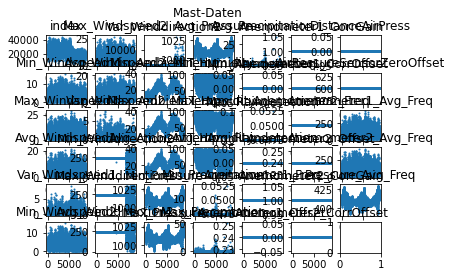

In [17]:
metmast = metmast.sort_values("Timestamp")
metmast = metmast.reset_index()

plot_data(metmast, "Mast-Daten", 10, (6, 7))

In [18]:
cols_to_drop = get_signals_with_low_variance(metmast)

In [19]:
# clean automatic features
metmast_clean = metmast.drop(cols_to_drop, axis=1)
# clean broken sensor data
metmast_clean = metmast_clean.drop(["Min_Winddirection2", "Max_Winddirection2", "Avg_Winddirection2", "Var_Winddirection2"], axis=1)

In [20]:
metmast_clean.describe()

,index,Min_Windspeed1,Max_Windspeed1,Avg_Windspeed1,Var_Windspeed1,Min_Windspeed2,Max_Windspeed2,Avg_Windspeed2,Var_Windspeed2,Min_AmbientTemp,...,Min_Humidity,Max_Humidity,Avg_Humidity,Min_Precipitation,Max_Precipitation,Avg_Precipitation,Max_Raindetection,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
count,87528.000000,87527.000000,87528.000000,87527.000000,87527.000000,87527.000000,87528.000000,87527.000000,87527.000000,87527.000000,...,87527.000000,87528.000000,87527.000000,87528.000000,87528.000000,87528.000000,87528.000000,87528.000000,87528.000000,87528.000000
mean,22793.190990,4.176164,8.374064,6.288644,0.932916,4.337556,8.226660,6.293094,0.767873,19.417026,...,65.819176,68.264795,66.996630,0.035234,0.100996,0.067407,0.000023,122.606069,122.702827,410.034275
std,14095.305666,2.565044,4.693669,3.635556,1.197053,2.735886,4.539296,3.629370,0.953883,5.408462,...,17.339855,16.871007,17.082442,0.642692,1.398972,1.043023,0.004780,72.875517,72.751763,5.236386
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-40.000000,...,0.000000,12.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,391.000000
25%,10940.750000,2.300000,4.700000,3.500000,0.160000,2.200000,4.700000,3.500000,0.150000,15.000000,...,54.000000,57.000000,55.000000,0.000000,0.000000,0.000000,0.000000,67.000000,67.000000,407.000000
50%,21881.500000,3.700000,7.500000,5.600000,0.490000,3.800000,7.500000,5.600000,0.440000,19.000000,...,67.000000,70.000000,69.000000,0.000000,0.000000,0.000000,0.000000,108.000000,109.000000,409.000000
75%,32822.250000,5.700000,11.300000,8.400000,1.210000,6.000000,11.000000,8.500000,1.000000,23.000000,...,79.000000,81.000000,80.000000,0.000000,0.000000,0.000000,0.000000,166.000000,167.000000,413.000000
max,52696.000000,17.800000,30.800000,23.100000,35.100000,17.300000,29.000000,22.900000,35.930000,39.000000,...,100.000000,100.000000,100.000000,55.000000,103.000000,93.000000,1.000000,459.000000,455.000000,429.000000


In [21]:
failures = pd.concat([failures_2016, failures_2017])

In [22]:
failures.head()

,Turbine_ID,Component,Timestamp,Remarks
0,T01,GEARBOX,2016-07-18T02:10:00+00:00,Gearbox pump damaged
1,T06,GENERATOR,2016-07-11T19:48:00+00:00,Generator replaced
2,T06,GENERATOR,2016-07-24T17:01:00+00:00,Generator temperature sensor failure
3,T06,GENERATOR,2016-09-04T08:08:00+00:00,High temperature generator error
4,T06,GENERATOR,2016-10-27T16:26:00+00:00,Generator replaced


In [23]:
failures.describe()

,Turbine_ID,Component,Timestamp,Remarks
count,28,28,28,28
unique,5,5,28,22
top,T06,HYDRAULIC_GROUP,2016-04-30T12:40:00+00:00,Hydraulic group error in the brake circuit
freq,8,8,1,3


# Datensätze in einen Datensatz zusammenführen
## Sensor- und Mastdaten mergen

In [24]:
merged_df = pd.merge(signals_clean.reset_index(drop=True), metmast_clean.reset_index(drop=True), on="Timestamp", how="left")

In [25]:
merged_df.describe(include="all")

,index_x,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,...,Min_Humidity,Max_Humidity,Avg_Humidity,Min_Precipitation,Max_Precipitation,Avg_Precipitation,Max_Raindetection,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
count,417141.000000,417141,417141,417141.000000,417141.000000,417141.000000,417141.000000,417137.000000,417141.000000,417141.000000,...,346254.000000,346258.000000,346254.000000,346258.000000,346258.000000,346258.000000,346258.000000,346258.000000,346258.000000,346258.000000
unique,NaN,4,104909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,T11,2016-10-30T02:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,104798,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,104285.811728,NaN,NaN,1190.486434,936.670981,1067.096004,67.925213,46.116209,64.032723,64.076216,...,65.894921,68.334947,67.069302,0.035627,0.102115,0.068154,0.000023,122.479354,122.583103,410.056129
std,60211.028260,NaN,NaN,631.827468,607.263095,608.989196,110.784748,15.495703,27.459765,26.806766,...,17.356803,16.889250,17.100406,0.646246,1.406688,1.048781,0.004807,72.660458,72.522507,5.254958
min,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,18.000000,19.000000,19.000000,...,0.000000,12.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,391.000000
25%,52142.000000,NaN,NaN,315.200000,194.800000,276.200000,13.300000,35.000000,43.000000,43.000000,...,54.000000,57.000000,56.000000,0.000000,0.000000,0.000000,0.000000,67.000000,67.000000,407.000000
50%,104285.000000,NaN,NaN,1417.700000,1231.100000,1274.600000,27.800000,44.000000,60.000000,61.000000,...,67.000000,70.000000,69.000000,0.000000,0.000000,0.000000,0.000000,108.000000,109.000000,409.000000
75%,156427.000000,NaN,NaN,1683.800000,1359.600000,1590.300000,71.200000,55.000000,76.000000,76.000000,...,79.000000,81.000000,80.000000,0.000000,0.000000,0.000000,0.000000,166.000000,167.000000,413.000000


In [26]:
# for column in merged_df.columns:
#     if (pd.api.types.is_numeric_dtype(merged_df[column])):
#         merged_df[column].fillna(merged_df[column].median(), inplace = True)

In [27]:
merged_df.drop(columns=["index_x"], inplace=True)

In [28]:
merged_df.sample(5)

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Min_Humidity,Max_Humidity,Avg_Humidity,Min_Precipitation,Max_Precipitation,Avg_Precipitation,Max_Raindetection,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq
123371,T01,2016-05-22T06:10:00+00:00,1358.6,201.5,670.5,474.5,34.0,36,36,36,...,90.0,91.0,90.0,0.0,0.0,0.0,0.0,59.0,59.0,410.0
126088,T01,2016-06-10T03:00:00+00:00,1379.1,148.3,848.4,454.2,36.0,39,39,39,...,90.0,93.0,92.0,0.0,0.0,0.0,0.0,68.0,68.0,406.0
335794,T07,2016-06-11T16:30:00+00:00,1560.1,1205.2,1359.5,82.3,46.0,66,66,66,...,54.0,57.0,56.0,0.0,0.0,0.0,0.0,117.0,118.0,407.0
73458,T06,2017-06-08T23:10:00+00:00,1693.2,1555.2,1656.5,21.2,62.0,86,87,87,...,60.0,62.0,61.0,0.0,0.0,0.0,0.0,125.0,141.0,406.0
224758,T11,2016-04-29T04:40:00+00:00,41.9,0.0,20.6,15.1,24.0,30,30,30,...,81.0,84.0,83.0,0.0,0.0,0.0,0.0,28.0,27.0,405.0


## Targets vorbereiten und mergen

In [42]:
failures_gearbox = failures[failures["Component"] == "HYDRAULIC_GROUP"]
failures_gearbox.reset_index(drop=True, inplace=True); failures_gearbox

,Turbine_ID,Component,Timestamp,Remarks
0,T06,HYDRAULIC_GROUP,2016-04-04T18:53:00+00:00,Error in pitch regulation
1,T11,HYDRAULIC_GROUP,2016-10-17T17:44:00+00:00,Hydraulic group error in the brake circuit
2,T06,HYDRAULIC_GROUP,2017-08-19T09:47:00+00:00,Oil leakage in Hub
3,T07,HYDRAULIC_GROUP,2017-06-17T11:35:00+00:00,Oil leakage in Hub
4,T07,HYDRAULIC_GROUP,2017-10-19T10:11:00+00:00,Oil leakage in Hub
5,T09,HYDRAULIC_GROUP,2017-09-16T15:46:00+00:00,Pitch position error related GH
6,T11,HYDRAULIC_GROUP,2017-04-26T18:06:00+00:00,Hydraulic group error in the brake circuit
7,T11,HYDRAULIC_GROUP,2017-09-12T15:30:00+00:00,Hydraulic group error in the brake circuit


Da die labels nicht auf 10 Minuten gerundet sind (Wie Sensor- und Mastdaten), wird das an dieser Stelle getan damit die Labels mit den restlichen Daten kompatibel sind:

In [43]:
def get_round_minute_diff(datetime_in: datetime) -> timedelta:
    min = datetime_in.minute
    rounded_min = round(min, -1)
    diff = rounded_min - min
    return timedelta(minutes=diff)

In [44]:
def convert_round_minute_to_time(datetime_in: datetime) -> datetime:
    td = get_round_minute_diff(datetime_in)
    return datetime_in + td

Für die Labels, werden 5 Stufen eingeführt, die alle 30 Tage um 1 erhöht werden. 
<br/>
<span style="color:red">TODO: Aktuell wird im Code nicht berücksichtigt, wenn sich labels überschneiden, da das für die Gearbox nicht der Fall ist.</span>

In [4]:
def create_failure_list(classes: list[str], days_per_class: int, target_name: str) -> pd.DataFrame:
    days_lookback = len(classes) * days_per_class
    ten_mins_of_n_days = int(24 * 60 * days_lookback / 10)
    failure_list = []
    for i, failure in enumerate(failures_gearbox):
        turbine_id = str(failures_gearbox["Turbine_ID"][i])
        failure_ts = str(failures_gearbox["Timestamp"][i])
        failure_datetime = datetime.fromisoformat(failure_ts)
        rounded_datetime = convert_round_minute_to_time(failure_datetime)
        for iterator, current_class in enumerate(classes):
            for j in range(ten_mins_of_n_days):
                delta = timedelta(minutes=j*10)
                # Prüfen ob obere und untere Schranke passen.
                is_in_class = delta >= timedelta(days=iterator*days_per_class) and delta < timedelta(days=(iterator+1) * days_per_class)
                if (is_in_class):
                    new_datetime = rounded_datetime - delta
                    datetime_formated = new_datetime.replace(tzinfo=timezone.utc)
                    failure_list.append([turbine_id, datetime_formated.isoformat(), current_class])
    
    failure_df = pd.DataFrame(failure_list, columns=["Turbine_ID", "Timestamp", target_name])

    return failure_df


In [46]:
class_target_name = "Risk Level"
risk_levels = ["low", "low-med", "medium", "med-high", "high"]
days_per_class = 30

failure_df = create_failure_list(classes=risk_levels, days_per_class=days_per_class, target_name=class_target_name)

Der Feature-Datensatz wird mit den Labels zusammengeführt. Dabei ist besonders wichtig, dass der Bezug zu der jeweiligen Turbine bestehen bleibt.

In [47]:
labeled_df = pd.merge(merged_df.reset_index(drop=True), failure_df.reset_index(drop=True), on=["Turbine_ID", "Timestamp"], how="left"); 

In [48]:
labeled_df[class_target_name].fillna(risk_levels[0], inplace = True)

In [49]:
labeled_df.describe(include="all")

,Turbine_ID,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,...,Max_Humidity,Avg_Humidity,Min_Precipitation,Max_Precipitation,Avg_Precipitation,Max_Raindetection,Anemometer1_Avg_Freq,Anemometer2_Avg_Freq,Pressure_Avg_Freq,Risk Level
count,417141,417141,417141.000000,417141.000000,417141.000000,417141.000000,417137.000000,417141.000000,417141.000000,417141.000000,...,346258.000000,346254.000000,346258.000000,346258.000000,346258.000000,346258.000000,346258.000000,346258.000000,346258.000000,417141
unique,4,104909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,T11,2016-10-30T02:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,low
freq,104798,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,356357
mean,NaN,NaN,1190.486434,936.670981,1067.096004,67.925213,46.116209,64.032723,64.076216,63.391827,...,68.334947,67.069302,0.035627,0.102115,0.068154,0.000023,122.479354,122.583103,410.056129,NaN
std,NaN,NaN,631.827468,607.263095,608.989196,110.784748,15.495703,27.459765,26.806766,26.083119,...,16.889250,17.100406,0.646246,1.406688,1.048781,0.004807,72.660458,72.522507,5.254958,NaN
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,18.000000,19.000000,19.000000,19.000000,...,12.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,391.000000,NaN
25%,NaN,NaN,315.200000,194.800000,276.200000,13.300000,35.000000,43.000000,43.000000,43.000000,...,57.000000,56.000000,0.000000,0.000000,0.000000,0.000000,67.000000,67.000000,407.000000,NaN
50%,NaN,NaN,1417.700000,1231.100000,1274.600000,27.800000,44.000000,60.000000,61.000000,60.000000,...,70.000000,69.000000,0.000000,0.000000,0.000000,0.000000,108.000000,109.000000,409.000000,NaN
75%,NaN,NaN,1683.800000,1359.600000,1590.300000,71.200000,55.000000,76.000000,76.000000,76.000000,...,81.000000,80.000000,0.000000,0.000000,0.000000,0.000000,166.000000,167.000000,413.000000,NaN


In [50]:
labeled_df[class_target_name].value_counts()

low         356357
medium       17245
low-med      16964
med-high     13634
high         12941
Name: Risk Level, dtype: int64

In [51]:
plt.rcParams["figure.figsize"] = (10,5)

# Daten in Training und Test Set splitten

In [59]:
# Alle Daten ab August 2017 liegen im Testset
split_criterion_reg = labeled_df["Timestamp"] >= "2017-04-00T00:00:00+00:00"

test_gearbox = labeled_df[split_criterion_reg].reset_index(drop=True)
train_gearbox = labeled_df[~split_criterion_reg].reset_index(drop=True)

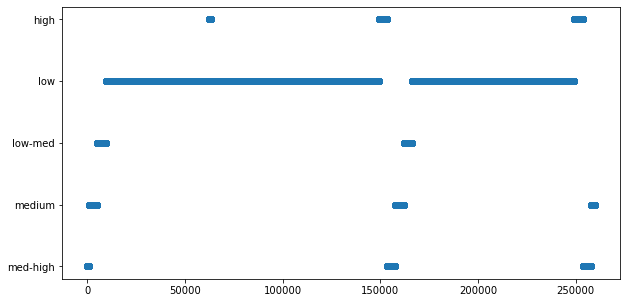

In [61]:

plt.scatter(x=train_gearbox.index, y=train_gearbox[class_target_name])
# train_simple_regression_gearbox.describe()

# Erzeugte Daten abspeichern

In [64]:
import os
os.makedirs("./data/multi", exist_ok=True)

In [65]:
train_gearbox.to_csv("./data/multi/train_hydraulic.csv")
test_gearbox.to_csv("./data/multi/test_hydraulic.csv")